<a href="https://colab.research.google.com/github/Maria-Evlakhova/GigachatTest/blob/main/%D0%91%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82_%22%D0%9A%D0%BB%D0%B8%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%86%D0%B8%D0%B8_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание простой вопросно-ответной системы
## Что из себя представляют вопросно-ответные системы с использованием языковых моделей

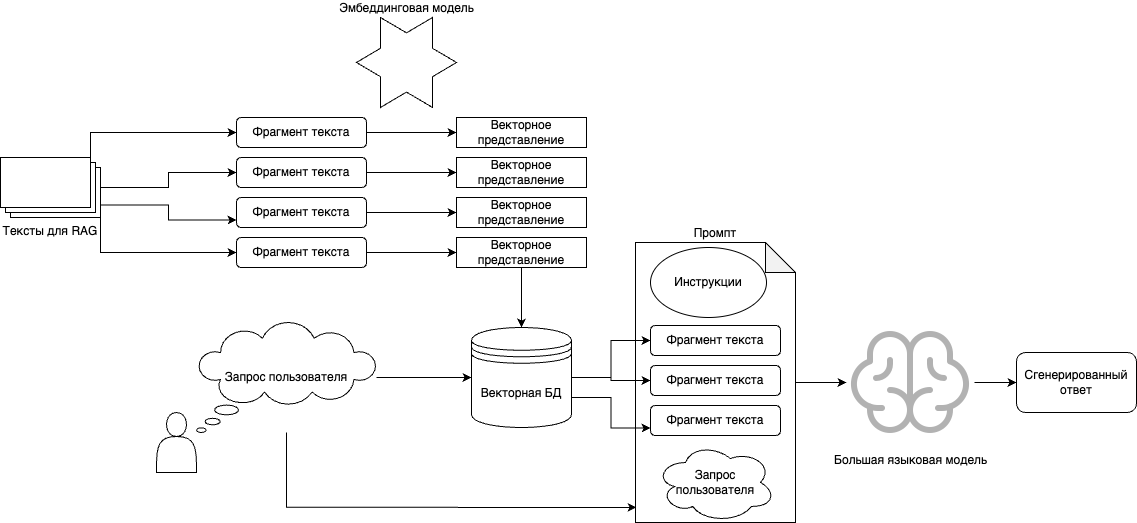

## Установка требуемых библиотек

В рамках туториала нам потребуется некоторое количество инструментов:
- `gigachain` - основной инструмент построения пайплайнов с большими языковыми моделями;
- `faiss-cpu` - используем векторное хранилище FAISS для размещения чанков (фрагментов текстов для контекста)и эмбеддингов (векторных представлений) этих чанков;
- `sentence-transformers` - библиотека для локального использования эмбеддинговых моделей с ресурса Hugging Face;
- `rank_bm25` - библиотека для работы с алгоритмами векторизации BM25 (вариации TF-IDF);
- `playwright` - библиотека для автоматизации браузера, в нашем случае для парсинга списка статей с веб-сайта.

In [3]:
!pip install gigachain faiss-cpu sentence-transformers rank_bm25 playwright langchain-community --quiet
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5

Также выполним установку браузера для сбора списка статей.

In [4]:
!playwright install

163.5 MiB [] 0% 10.8s163.5 MiB [] 0% 106.4s163.5 MiB [] 0% 110.6s163.5 MiB [] 0% 90.2s163.5 MiB [] 0% 58.4s163.5 MiB [] 0% 44.7s163.5 MiB [] 0% 33.8s163.5 MiB [] 0% 25.4s163.5 MiB [] 0% 21.3s163.5 MiB [] 1% 13.4s163.5 MiB [] 1% 14.3s163.5 MiB [] 2% 10.2s163.5 MiB [] 2% 8.8s163.5 MiB [] 3% 8.1s163.5 MiB [] 3% 7.3s163.5 MiB [] 4% 6.5s163.5 MiB [] 5% 5.7s163.5 MiB [] 5% 5.8s163.5 MiB [] 6% 5.3s163.5 MiB [] 7% 5.0s163.5 MiB [] 7% 4.6s163.5 MiB [] 8% 4.4s163.5 MiB [] 9% 4.2s163.5 MiB [] 10% 3.9s163.5 MiB [] 10% 3.8s163.5 MiB [] 11% 3.6s163.5 MiB [] 12% 3.4s163.5 MiB [] 13% 3.2s163.5 MiB [] 14% 3.0s163.5 MiB [] 16% 2.8s163.5 MiB [] 17% 2.7s163.5 MiB [] 18% 2.6s163.5 MiB [] 19% 2.5s163.5 MiB [] 20% 2.4s163.5 MiB [] 21% 2.3s163.5 MiB [] 21% 2.4s163.5 MiB [] 22% 2.4s163.5 MiB [] 23% 2.3s163.5 MiB [] 25% 2.1s163.5 MiB [] 26% 2.1s163.5 MiB [] 27% 2.0s163.5 MiB [] 28% 2.0s163.5 MiB [] 30% 1.9s163.5 MiB [] 31% 1.9s163.5 MiB [] 32% 1.8s163.5 MiB [] 33% 1.8s163.5 MiB [] 34% 1.7s163.5 MiB [] 35% 1.7s1

## Выполним сбор статей
В качестве источника знаний используем статьи с научно-популярного сайта [N + 1](https://nplus1.ru/). Возьмем последние статьи по космонавтике.

Используем `AsyncChromiumLoader` из GigaChain для загрузки страницы. Этот инструмент приходится использовать, потому что выборка статей по направлениям подгружает перечень статей не сразу, а значит получить его обычным запросом `requests.get()` не получится.

Из-за асинхронной работы `AsyncChromiumLoader` сделаем сбор статей отдельным скриптом.

В результате выполнения скрипта мы получим отдельный текстовый файл со ссылками на статьи по космической тематике.

In [8]:
%%writefile parser.py

from langchain_community.document_loaders import AsyncChromiumLoader
from bs4 import BeautifulSoup

# Инициализируем загрузчик
loader = AsyncChromiumLoader(["https://org.gnicpm.ru/pomosh/klinicheskie-rekomendaczii.html"])
html = loader.load()
articles = 'download'
with open('page.html', 'w') as f:
  f.write(html[0].page_content)
soup = BeautifulSoup(html[0].page_content, 'html.parser')
links = []
with open('links.txt', 'w') as f:
  for link in soup.find_all('a', class_=articles):
    print(link)
    links.append(link['href'])
    f.write(link['href']+' ')


Overwriting parser.py


In [9]:
!python parser.py

USER_AGENT environment variable not set, consider setting it to identify your requests.
<a class="download" href="https://org.gnicpm.ru/wp-content/uploads/2024/01/323-fz.pdf">Федеральный закон от 21.11.2011 № 323-ФЗ (ред. от 25.12.2023) «Об основах охраны здоровья граждан в Российской Федерации»</a>
<a class="download" href="https://org.gnicpm.ru/wp-content/uploads/2024/04/pp-rf-ot-17.11.2021-№1968.pdf">Постановление Правительства РФ от 17.11.2021 № 1968 (ред. от 14.03.2024) «Об утверждении Правил поэтапного перехода медицинских организаций к оказанию медицинской помощи на основе клинических рекомендаций, разработанных и утвержденных в соответствии с частями 3, 4, 6 — 9 и 11 статьи 37 Федерального закона «Об основах охраны здоровья граждан в Российской Федерации»</a>
<a class="download" href="https://org.gnicpm.ru/wp-content/uploads/2024/05/postanovlenie-pravitelstva-rf-ot-28_12_2023-n-2353-v-redakczii-ot-23.03.2024g.pdf">Постановление Правительства Российской Федерации от 28.12.2023 №

## Подготовка фрагментов статей, векторизация и загрузка в векторную БД

Откроем файл со ссылками.

In [10]:

with open('links.txt') as f:
  sources = f.read()

print(sources.split())


['https://org.gnicpm.ru/wp-content/uploads/2024/01/323-fz.pdf', 'https://org.gnicpm.ru/wp-content/uploads/2024/04/pp-rf-ot-17.11.2021-№1968.pdf', 'https://org.gnicpm.ru/wp-content/uploads/2024/05/postanovlenie-pravitelstva-rf-ot-28_12_2023-n-2353-v-redakczii-ot-23.03.2024g.pdf', 'https://org.gnicpm.ru/wp-content/uploads/2024/04/pp-ot-14.03.2024-№299.pdf', 'https://cr.minzdrav.gov.ru/preview-cr/62_3', 'https://cr.minzdrav.gov.ru/preview-cr/155_2', 'https://cr.minzdrav.gov.ru/preview-cr/160_1', 'https://cr.minzdrav.gov.ru/preview-cr/382_1', 'https://cr.minzdrav.gov.ru/preview-cr/619_2', 'https://cr.minzdrav.gov.ru/preview-cr/569_1', 'https://cr.minzdrav.gov.ru/preview-cr/156_2', 'https://cr.minzdrav.gov.ru/preview-cr/752_1', 'https://cr.minzdrav.gov.ru/preview-cr/290_2', 'https://cr.minzdrav.gov.ru/preview-cr/277_1', 'https://cr.minzdrav.gov.ru/preview-cr/273_4', 'https://cr.minzdrav.gov.ru/preview-cr/655_1', 'https://cr.minzdrav.gov.ru/preview-cr/603_2', 'https://cr.minzdrav.gov.ru/prev

Импортируем нужные инструменты.


In [11]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores.faiss import FAISS
from langchain_core.documents import Document

In [12]:
import os
os.environ['USER_AGENT'] = 'myagent'
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

Осуществим загрузку веб-страниц по ссылкам.

In [13]:
loader = WebBaseLoader(sources.split())

In [14]:
docs = loader.load()

In [15]:
len(docs)

30

Разделим тексты статей на фрагменты длиной 500 символов и перекрытием в 100 символов.

In [16]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                              chunk_overlap=100)
split_docs = text_splitter.split_documents(docs)

In [17]:
len(split_docs)

19038

In [18]:
split_docs[1]

Document(metadata={'source': 'https://org.gnicpm.ru/wp-content/uploads/2024/01/323-fz.pdf'}, page_content='xœ�}\x18Ä6Ny¯ìØ¥Ö\x03¢¤\x11˜.ã1¶ÃĞ\x0bv¨Àã$Ü\x06à+Øª¯Ø30��Ju=»\x014\xa0×Ü¦)Å"s”\xadj\'|QêÓƒdÒªU\x1aµZR?\x0b…á!h[…ÅNãeŸ·ÌãÁ²<9�i³°\x0eÕzÆîò0\x16öä¡\x11µj\x0eğ+…T}¤JRodı\x01\x1cQ•ÃV8KĞæÃ-§²ş\x11iqâ’`d\x11&\x06Ó•�ùä*GœbJ„æq±\x1eŸ†}\x08fÑ‰f–ÈLØ¡fu4�QO\x12\x04A\x10\x0411Œá)õl`’]\x0eA\x10g"ü\x1bp¸ƒn†wõaĞƒ>ü!\x18À€j\x04#ª\tL¨f°„?\x00‹P+ØÂïƒ\rì¨vp\xa0: \x015\x01\x12Q\x13!\tÕ\tÉ¨I�‚š,4\x05RÃïA*¤‡�AšĞtp¡º \x135\x03²P3…f�\x07Õ\r^T\x0fê¿À\x0bÙ¨Ù0\x05Õ\x079¨S \x175\x07¦†ß…\\ÈC�*4\x0fòÃÿ„iàGÍ‡é¨~(@�\x0e…áw\xa0@h!\x14£\x16Á\x0cÔb(A�\x01¥¨%P†Z\nå¨e¨oÃL¨@-‡JÔ\n¡•P\x1d~\x0bª\xa0\x06u\x16ÌF\xad\x16Z\x03ç\xa0Î†ZÔs \x10ş?¨…9á7!\x00õ¨s„ÖA\x03j=4¡6À\\ÔF¡M0\x0fu.œ‹:\x0f\x16„ÿ\x01óaaø\r8\x17ÎC] t!œ�z\x1e,B=\x1f–\xa0.‚¥¨‹a\x19ê\x12X\x1e~\x1d–')

Создадим ретривер и векторное хранилище для врагментов текста.

- [Рейтинг ретриверов для английского языка](https://huggingface.co/spaces/mteb/leaderboard)
- [Рейтинг ретриверов для русского языка](https://github.com/avidale/encodechka#%D0%BB%D0%B8%D0%B4%D0%B5%D1%80%D0%B1%D0%BE%D1%80%D0%B4)
- [Эмбеддинговая модель, которую используем в этом туториале](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2)

In [19]:
%%time
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(model_name=model_name,
                                  model_kwargs=model_kwargs,
                                  encode_kwargs=encode_kwargs)

vector_store = FAISS.from_documents(split_docs, embedding=embedding)

<timed exec>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

CPU times: user 2h 6min 44s, sys: 7min 47s, total: 2h 14min 31s
Wall time: 2h 15min 22s


Зададим параметры извлечения. В нашем случае установим, что на запрос должны возвращаться 5 фрагментов, наиболее близких по смыслу.

In [51]:
embedding_retriever = vector_store.as_retriever(search_kwargs={"k": 5})

## Создание генеративной части пайплайна и составление цепочки RAG системы

Используем авторизационные данные для подключения к GigaChat API.

In [52]:
from google.colab import userdata
auth = userdata.get('SBER_AUTH')

Импортируем необходимые компоненты

In [53]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models.gigachat import GigaChat
from langchain.chains import create_retrieval_chain

Создадим объект `GigaChat` и подготовим промпт для вопросно-ответной системы.

In [54]:

llm = GigaChat(credentials=auth,
              model='GigaChat:latest',
               verify_ssl_certs=False,
               profanity_check=False)
prompt = ChatPromptTemplate.from_template('''Ответь на вопрос пользователя. \
Используй при этом только информацию из контекста. Если в контексте нет \
информации для ответа, сообщи об этом пользователю.
Контекст: {context}
Вопрос: {input}
Ответ:'''
)

<ipython-input-54-7895cbad50b3>:1: LangChainDeprecationWarning: The class `GigaChat` was deprecated in LangChain 0.3.5 and will be removed in 1.0. An updated version of the class exists in the langchain-gigachat package and should be used instead. To use it run `pip install -U langchain-gigachat` and import as `from langchain_gigachat import GigaChat`.
  llm = GigaChat(credentials=auth,


Создадим цепочку `create_stuff_documents_chain`, которая будет частью нашей вопросно-ответной цепочки. Это нужно, чтобы подавать фрагменты текстов из векторной БД в промпт языковой модели. Промпт представляет из себя форматированную строку, а франменты являются экземплярами класса `Document`. Чтобы не писать код по извлечению атрибута `page_content` из `Document`, используем цепочку `create_stuff_documents_chain`, где это автоматизировано.

In [55]:
document_chain = create_stuff_documents_chain(
    llm=llm,
    prompt=prompt
    )

А теперь создадим вопросно-ответную цепочку с помощью функции `create_retrieval_chain()`.

In [56]:
retrieval_chain = create_retrieval_chain(embedding_retriever, document_chain)

## Запустим нашу вопросно-ответную систему

Пусть RAG-система ответит на следующие 5 вопросов:
- Какие космические аппараты запускал Китай к Луне?
- Когда Хаббл вернулся к работе?
- Какая есть информация о неудачных запусках?
- Есть ли какая-то информация, связанная с именем древнегреческого математика?
- Дай информацию, связанную с лазерами.

In [58]:

# Используем вкладку "Секреты" левой панели Colab для хранения ключей
from google.colab import userdata
client_id = userdata.get('SBER_ID')
secret = userdata.get('SBER_SECRET')
auth = userdata.get('SBER_AUTH')

In [59]:
import base64
credentials = f"{client_id}:{secret}"
encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')


In [61]:
encoded_credentials == auth

False

In [57]:
import requests
import uuid

def get_token(auth_token, scope='GIGACHAT_API_PERS'):
    """
      Выполняет POST-запрос к эндпоинту, который выдает токен.

      Параметры:
      - auth_token (str): токен авторизации, необходимый для запроса.
      - область (str): область действия запроса API. По умолчанию — «GIGACHAT_API_PERS».

      Возвращает:
      - ответ API, где токен и срок его "годности".
      """
    # Создадим идентификатор UUID (36 знаков)
    rq_uid = str(uuid.uuid4())

    # API URL
    url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

    # Заголовки
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'application/json',
        'RqUID': rq_uid,
        'Authorization': f'Basic {auth_token}'
    }

    # Тело запроса
    payload = {
        'scope': scope
    }

    try:
        # Делаем POST запрос с отключенной SSL верификацией
        # (можно скачать сертификаты Минцифры, тогда отключать проверку не надо)
        response = requests.post(url, headers=headers, data=payload, verify=False)
        return response
    except requests.RequestException as e:
        print(f"Ошибка: {str(e)}")
        return -1


In [62]:
response = get_token(auth)
if response != 1:
  print(response.text)
  giga_token = response.json()['access_token']

{"access_token":"eyJjdHkiOiJqd3QiLCJlbmMiOiJBMjU2Q0JDLUhTNTEyIiwiYWxnIjoiUlNBLU9BRVAtMjU2In0.BZ9lQyWifZLhbq2IF-NEVLas28tZGaklfg3E3SzCo16VZ-wuUxz9ius1dyPLljnsq3vHVcaO2DX7zj2NA2g0OmrdCJKPZAW1k4_wQL0gGKHM8esfFTviAvcKmiZHlGqbYtbESPz2luleoQbO0btsHbB-mMFgg6LmlAUW7rgWxbBe8gGFKx-RJruoj4hHJIyl5JYq-F1E4EOnwoE17K-8PyMvmXthoK3XnYkl31TXK5zpKdAyeuHxETO6XWyVYXfOeITKgCPEyWz6XvO8ufjBIJaVc_0m2ifOdwK02tCNz0qO3yILUC76EA5id4NE4ng9HR41e6bw21eHxrkntKVMCw.LSHRsp9aQEprR31DTZ5ecg.mm4ooqYSSAamuSSiL1418E1nk39ZH8lMP94zGx-wsvCJp-IAYviEGby2rsJSGWiLqUSPpi19KEClQHmLe6BGlIDI3CQo0PlzrvT5nR4gq4uRiJNCIvf0bwmZC8ecXBqrFZGJcyixDpeESgouVBK29GFNucyw_g981CcF_1XjfFSv1sk6mJzrdiIcK33uH6wFUSuJqeXzMCzRbez6jTOG7uBbEO2U33MHFnWIBDQOiVwPBNjauNQpXCyRcK4Tn_ajRDvTvjG3CglzTV5jbw0gpEFeqcG3hfokA8_GNcfjSn8rlU8YYCqEzeDJ0gw57DyCukPw-LBYBicns4WK5wPoC9dyUBClRucgN07aAXeniRZo9nGtIdLsJTW540AjpZ6Wv-53ukbEV7XJnjIdmCTOwEPU7wXH4Uf1sk9EY5tXCkyLJzGiUlaKCY4vYUiXIQowupuTdxfTTchCqqYISpM6bpBd5MUVx4zrlIB_ZNWn9oEOdN1xF5UCVXoi7uOAvY4aSupIuGQw_ST01XpWPKovs-AJ1TbpR

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ngw.devices.sberbank.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [63]:
import requests

url = "https://gigachat.devices.sberbank.ru/api/v1/models"

payload={}
headers = {
  'Accept': 'application/json',
  'Authorization': f'Bearer {giga_token}'
}

response = requests.request("GET", url, headers=headers, data=payload, verify=False)

print(response.text)

{"object":"list","data":[{"id":"GigaChat","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-2","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-2-Max","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-2-Max-preview","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-2-Pro","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-2-Pro-preview","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-2-preview","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-Max","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-Max-preview","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-Plus","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-Plus-preview","object":"model","owned_by":"salutedevices","type":"chat"},{"id":"GigaChat-Pro","object":"model","owned_by":"sal

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gigachat.devices.sberbank.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [70]:
q1 = 'Сахарный диабет 2 типа какой код мкб'

In [71]:
resp1 = retrieval_chain.invoke(
    {'input': q1}
)

In [72]:
resp1

{'input': 'Сахарный диабет 2 типа какой код мкб',
 'context': [Document(id='cea6af13-be1c-466a-a252-c1e26027a78c', metadata={'source': 'https://medi.ru/filters/doc_type/manuals/oftalmologiya/', 'title': 'Офтальмология', 'description': 'Клинические рекомендации МЗ РФ…', 'language': 'ru'}, page_content='Травма глаза закрытая\n\nКлинические рекомендации\n\n\n\t\t\t10 окт. 2016 г..\n\t\t\n\n читать..\n\n\n\n\n\n\n\nСахарный диабет: диабетическая ретинопатия, диабетический макулярный отек\n\nКлинические рекомендации\n\n\n\t\t\t10 окт. 2016 г..\n\t\t\n\n читать..\n\n\n\n\n\n\n\nРетинопатия недоношенных, активная фаза\n\nКлинические рекомендации\n\n\n\t\t\t10 окт. 2016 г..\n\t\t\n\n читать..\n\n\n\n\n\n\n\nРетинобластома у детей\n\nКлинические рекомендации\n\n\n\t\t\t10 окт. 2016 г..\n\t\t\n\n читать..\n\n\n\n\n\n\n\nРегматогенная отслойка сетчатки\n\nКлинические рекомендации'),
  Document(id='e164466d-130c-4fc5-a168-bad84616acea', metadata={'source': 'https://medi.ru/filters/doc_type/manuals

In [ ]:
q2 = 'Когда Хаббл вернулся к работе?'

In [ ]:
resp2 = retrieval_chain.invoke(
    {'input': q2}
)

In [ ]:
resp2

{'input': 'Когда Хаббл вернулся к работе?',
 'context': [Document(id='85b6d49c-2600-4479-8f5a-a44a34abf2cd', metadata={'source': 'https://nplus1.ru/news/2024/12/10/spacex-super-heavy-static-fire-test-for-ift7', 'title': 'Первая ступень Starship успешно прошла прожиг перед седьмым испытательным полетом. Запуск может состояться уже через месяц', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='и\xa0посадки на\xa0башню обслуживания была направлена по\xa0альтернативной траектории в\xa0Мексиканский залив. Как стало известно позднее, возвращению ускорителя помешала неисправность оборудования башни обслуживания, которую выявила автоматическая процедура проверки во\xa0время фазы торможения после разделения ступеней.'),
  Document(id='e0d86104-16ae-4819-9716-8277dad729f1', metadata={'source': 'https://nplus1.ru/news/2025/01/10/spacex-2', 'title': 'Starship впервые выведет полезную нагрузку во\xa0время седьмого испытательного полета. Запус

In [ ]:
q3 = 'Какая есть информация о неудачных запусках?'

In [ ]:
resp3 = retrieval_chain.invoke(
    {'input': q3}
)

In [ ]:
resp3

{'input': 'Какая есть информация о неудачных запусках?',
 'context': [Document(id='e376d50b-bf5f-4a19-8d1a-699125b5c400', metadata={'source': 'https://nplus1.ru/news/2025/02/13/starship-longest-static-fire-test', 'title': 'SpaceX провела самый долгий прожиг второй ступени Starship. Двигатели корабля работали почти минуту', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='столь длительное испытание было необходимо для тестирования нового оборудования и\xa0проверки работы двигателей на\xa0разных уровнях тяги, чтобы смоделировать различные условия, возникающие в\xa0двигательной системе во\xa0время полета. Полученные данные будут использованы для модернизации оборудования корабля и\xa0корректировки профиля полета перед следующим запуском.'),
  Document(id='821e26d0-9057-463d-9218-e8603512bc41', metadata={'source': 'https://nplus1.ru/blog/2024/12/11/the-mythology-of-the-soviet-space', 'title': '«Мифология советского космоса». Почему к

In [ ]:
q4 = 'Есть ли какая-то информация, связанная с именем древнегреческого математика?'

In [ ]:
resp4 = retrieval_chain.invoke(
    {'input': q4}
)

In [ ]:
resp4

{'input': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'context': [Document(id='2333cd92-2569-437b-a587-6015f1187b32', metadata={'source': 'https://nplus1.ru/news/2024/12/02/tmds-system', 'title': 'Роботизированная платформа с\xa0лебедкой поможет робоспелеологу спуститься в\xa0инопланетную пещеру. Она позволяет роботу отсоединяться после спуска для продолжения исследований в\xa0глубине', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='Пещеры вулканического происхождения на\xa0Марсе и\xa0Луне привлекают пристальное внимание ученых. Благодаря защищенности от\xa0метеоритных бомбардировок, экстремальных колебаний температуры, ультрафиолетового излучения и\xa0космических заряженных частиц, эти полости могли сохранить в\xa0себе важную информацию о\xa0геологической истории небесного тела и\xa0возможные следы внеземной жизни. Кроме того, инопланетные пещеры рассматриваются как потенциальные места, где

In [ ]:
q5 = "Дай информацию, связанную с лазерами."

In [ ]:
resp5 = retrieval_chain.invoke(
    {'input': q5}
)

In [ ]:
resp5

{'input': 'Дай информацию, связанную с лазерами.',
 'context': [Document(id='cc73f398-c967-4fdb-8868-ca421e63b275', metadata={'source': 'https://nplus1.ru/news/2025/01/10/spacex-2', 'title': 'Starship впервые выведет полезную нагрузку во\xa0время седьмого испытательного полета. Запуск намечен на\xa014\xa0января', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}, page_content='В\xa0оборудование башни также были внесены изменения. В\xa0частности, оно получило дополнительную защиту, чтобы исключить вероятность повреждений во\xa0время старта ракеты, как это случилось во\xa0время предыдущего запуска Starship, что привело к\xa0отмене посадки ускорителя. На\xa0консолях крана установили несколько радиолокаторов, которые будут использоваться для повышения точности измерения расстояния между «руками» манипулятора и\xa0возвращающимся ступенями ракеты.'),
  Document(id='67265747-1e55-448e-b808-e4a4f57697a5', metadata={'source': 'https://nplus1.ru/news/2025

## Использование ретривера BM25

Теперь для векторизации фрагментов и запроса пользователя используем более простую модель. Модели BM25 основана на векторизации TF-IDF. То есть в отличие от эмбеддинговой модели, где вектор представляет собой числовое представление семантического смысла, модели BM25 векторизируют текст по словам. Можно сказать, что поиск с помощью BM25 - это поиск по ключевым словам.

Поскольку BM25 работает со словами, а не со смыслами, нужно как в классическом NLP выполнить предобработку текстов, чтобы уменьшить словарь.

In [ ]:
import string


def tokenize(s):
    return s.lower().translate(str.maketrans("", "", string.punctuation)).split(" ")

In [ ]:
!pip install rank_bm25

In [ ]:
bm25_retriever = BM25Retriever.from_documents(
      documents=split_docs,
      preprocess_func=tokenize,
      k=5,
  )

NameError: name 'BM25Retriever' is not defined

In [ ]:
bm25_retriever.get_relevant_documents(q5)

NameError: name 'bm25_retriever' is not defined

In [ ]:
bm25_chain = create_retrieval_chain(bm25_retriever, document_chain)

In [ ]:
resp5_2 = bm25_chain.invoke(
    {'input': q5}
)

In [ ]:
resp5_2

{'input': 'Дай информацию, связанную с лазерами.',
 'context': [Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplus1.ru/news/2024/04/09/delta-heavy-finally', 'title': 'Ракета Delta IV\xa0Heavy отправилась в\xa0свой финальный полет. Она летала в\xa0космос 20\xa0лет', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с редакцией: [email\xa0protected]', metadata={'source': 'https://nplus1.ru/news/2024/05/09/tess-on', 'title': 'Телескоп TESS возобновил научные наблюдения. Он\xa0второй раз за\xa0месяц был в\xa0безопасном режиме', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Сайт может содержать контент, не предназначенный для лиц младше 18 лет.\nСвязь с ре

In [ ]:
resp4_2 = bm25_chain.invoke(
    {'input': q4}
)

In [ ]:
resp4_2

{'input': 'Есть ли какая-то информация, связанная с именем древнегреческого математика?',
 'context': [Document(page_content='Андрей Фокин\n\n\nКомпания SpaceX обнародовала результаты расследования причин последовательных взрывов первой и\xa0второй ступеней ракеты-носителя Starship во\xa0время второго испытательного полета, состоявшегося 18\xa0ноября 2023\xa0года. Информация появилась на\xa0сайте компании.\n\n\n\nЧитать дальше\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nО нас\n\n\nСложность\n\n\nРекламодателям\n\n\nАвторам\n\n\n\n© 2024 N + 1 Интернет-издание / Свидетельство о регистрации СМИ Эл № ФС77-67614', metadata={'source': 'https://nplus1.ru/news/2024/04/03/iss-kaboom', 'title': 'Обломок выброшенных с\xa0МКС аккумуляторов пробил крышу дома жителя Флориды. Аккумуляторы выбросили с\xa0борта станции в\xa02021 году', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Александр Войтюк\n\n\n\nКосмическ

In [ ]:
resp3_2 = bm25_chain.invoke(
    {'input': q3}
)

In [ ]:
resp3_2

{'input': 'Какая есть информация о неудачных запусках?',
 'context': [Document(page_content='Андрей Фокин\n\n\nКомпания SpaceX обнародовала результаты расследования причин последовательных взрывов первой и\xa0второй ступеней ракеты-носителя Starship во\xa0время второго испытательного полета, состоявшегося 18\xa0ноября 2023\xa0года. Информация появилась на\xa0сайте компании.\n\n\n\nЧитать дальше\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nО нас\n\n\nСложность\n\n\nРекламодателям\n\n\nАвторам\n\n\n\n© 2024 N + 1 Интернет-издание / Свидетельство о регистрации СМИ Эл № ФС77-67614', metadata={'source': 'https://nplus1.ru/news/2024/04/03/iss-kaboom', 'title': 'Обломок выброшенных с\xa0МКС аккумуляторов пробил крышу дома жителя Флориды. Аккумуляторы выбросили с\xa0борта станции в\xa02021 году', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='Александр Войтюк\n\n\n\nКосмический телескоп «Хаббл» 29\xa0апреля 

In [ ]:
resp2_2 = bm25_chain.invoke(
    {'input': q2}
)

In [ ]:
resp2_2

{'input': 'Когда Хаббл вернулся к работе?',
 'context': [Document(page_content='о борьбе за первенство в области пилотируемых космических полетов. Предлагаем вам ознакомиться с фрагментом о том, что заставило Сергея Королева пойти наперекор себе и дать космонавтам доступ к ручному управлению космическим кораблем.', metadata={'source': 'https://nplus1.ru/news/2024/05/09/change-6-lunar-orbit', 'title': 'Китайская автоматическая станция «Чанъэ-6» вышла на\xa0окололунную орбиту. Она может высадиться на\xa0Луну в\xa0начале июня', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='После этого взлетный модуль доставит капсулу на\xa0окололунную орбиту, где перегрузит ее\xa0на\xa0служебный модуль после стыковки с\xa0ним. В\xa0конце служебный модуль доставит капсулу к\xa0Земле и\xa0сбросит в\xa0атмосферу. Связь с\xa0Землей аппаратов при работе на\xa0Луне обеспечит спутник-ретранслятор «Цюэцяо-2», запущенный ранее.', metadata={'so

In [ ]:
resp1_2 = bm25_chain.invoke(
    {'input': q1}
)

In [ ]:
resp1_2

{'input': 'Какие космические аппараты запускал Китай к Луне?',
 'context': [Document(page_content='о борьбе за первенство в области пилотируемых космических полетов. Предлагаем вам ознакомиться с фрагментом о том, что заставило Сергея Королева пойти наперекор себе и дать космонавтам доступ к ручному управлению космическим кораблем.', metadata={'source': 'https://nplus1.ru/news/2024/05/09/change-6-lunar-orbit', 'title': 'Китайская автоматическая станция «Чанъэ-6» вышла на\xa0окололунную орбиту. Она может высадиться на\xa0Луну в\xa0начале июня', 'description': 'N + 1 — главное издание о науке, технике и технологиях', 'language': 'ru'}),
  Document(page_content='15:53\n\n\n22.03.24\n\n\n\n\n\n2.9\n\n\nКосмонавтика\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Китай запустил спутник-ретранслятор «Цюэцяо-2» для будущих лунных аппаратов\n        \nОн\xa0будет обеспечивать связь с\xa0Землей\n\nАлександр Войтюк\n\n\nКитай отправил к\xa0Луне аппарат для связи будущих лунных миссий с\xa0Земле

## Сохранение ответов в файл

В последующих туториалах мы попробуем оценить качество ответов, даваемых RAG-системой. Для этого сохраним их пока что в файл.

In [ ]:
rows = []
results = [
    resp1, resp2, resp3, resp4, resp5,
    resp1_2, resp2_2, resp3_2, resp4_2, resp5_2,
]
for data in results:
  for context in data['context']:
    row = {
        'input': data['input'],
        'context': context.page_content,
        'source': context.metadata['source'],
        'title': context.metadata['title'],
        'description': context.metadata['description'],
        'language': context.metadata['language'],
        'answer': data['answer']
    }
    rows.append(row)

In [ ]:
import pandas as pd
df = pd.DataFrame(rows)

df.to_csv('output.csv', index=False)

## Вопросно-ответная система с двумя ретриверами
Создадим гибрид, где два из пяти фрагментов будут извлекаться по эмбеддингам, а еще три по векторам, полученным с помощью модели BM25.

In [ ]:
embedding_retriever = vector_store.as_retriever(search_kwargs={"k": 2})
bm25_retriever = BM25Retriever.from_documents(
    documents=split_docs,
    preprocess_func=tokenize,
    k=3,
)

NameError: name 'vector_store' is not defined

In [ ]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[embedding_retriever, bm25_retriever],
    weights=[0.4, 0.6],
)

In [ ]:
from langchain.chains import RetrievalQA
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=ensemble_retriever,
    return_source_documents=True,
)

In [ ]:
qa.invoke({"query": q1})

In [ ]:
qa.invoke({"query": q2})

In [ ]:
qa.invoke({"query": q3})

In [ ]:
qa.invoke({"query": q4})

In [ ]:
qa.invoke({"query": q5})